In [1]:
from IPython.display import Image

### basics

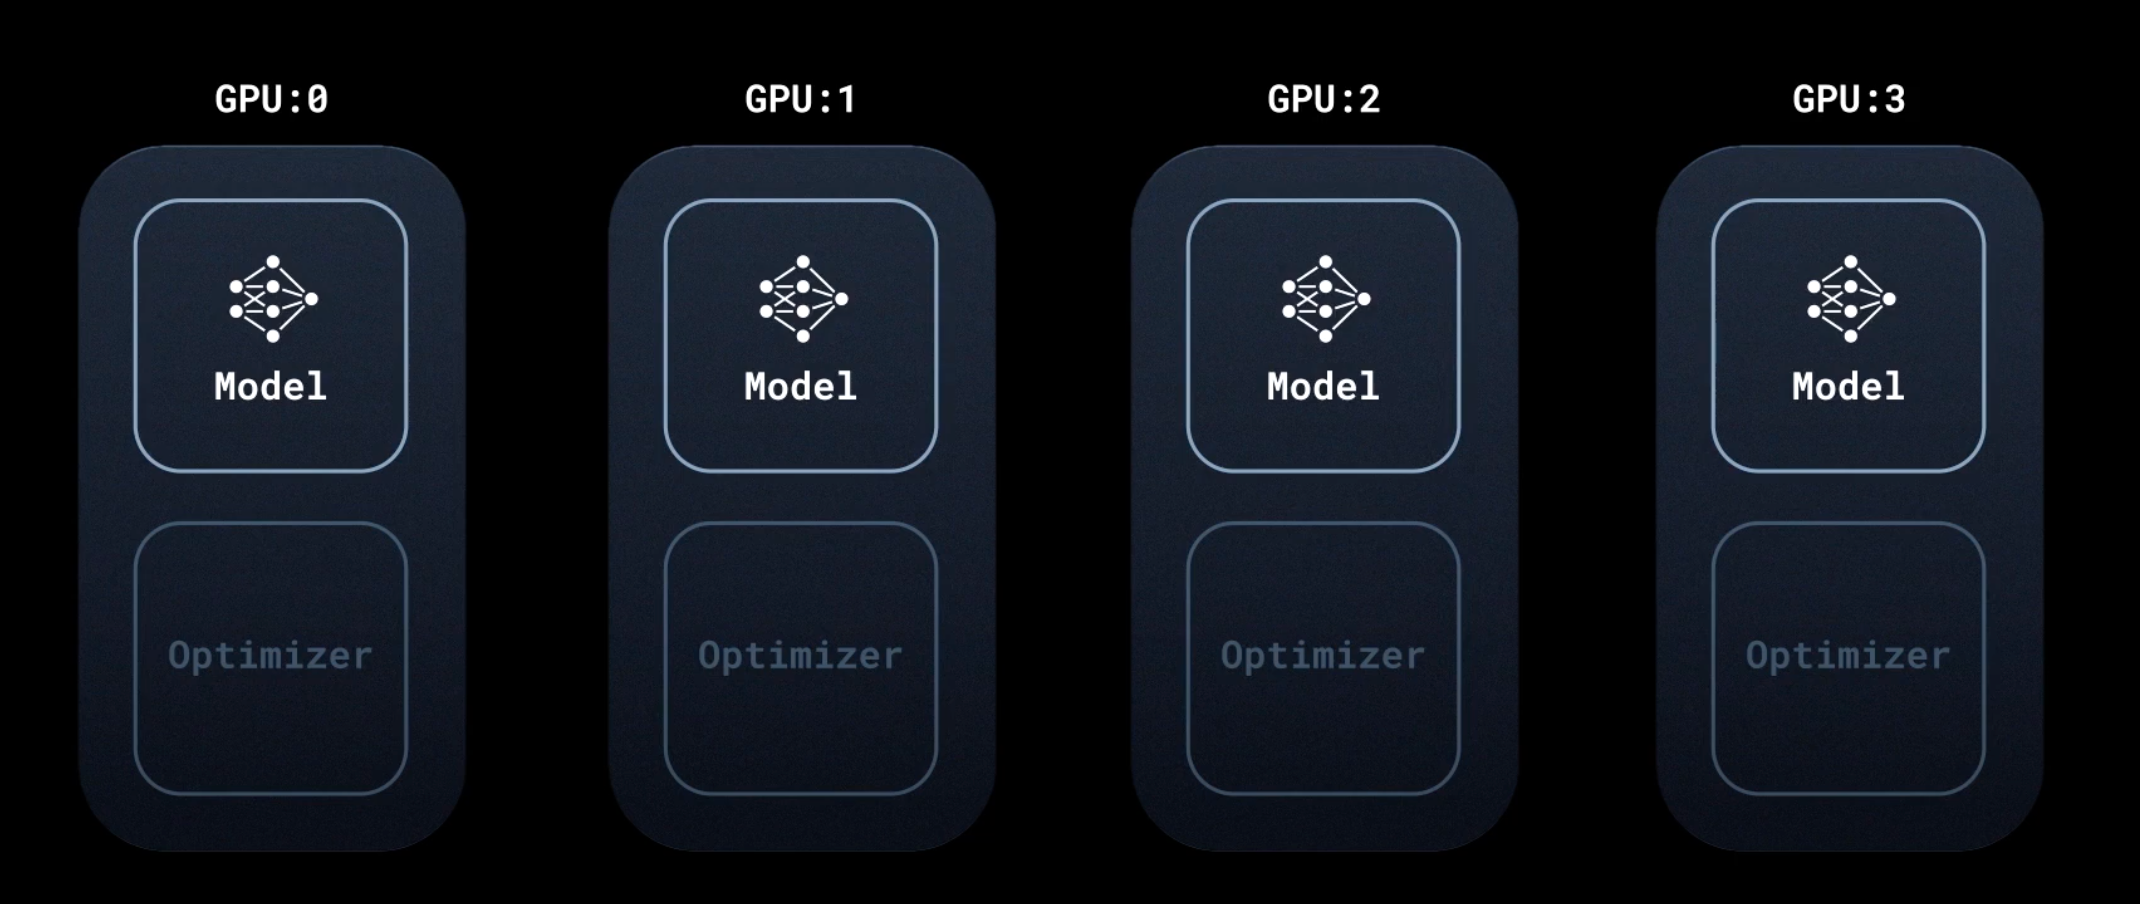

In [2]:
Image('./imgs/gpus.png', width=600)

- 分布式数据并行时，模型（model parameters）/ 优化器（optimizer states）每张卡都会拷贝一份（replicas）
    - DDP在训练过程中，始终在卡间维持着模型参数和优化器状态的同步一致性
- Data Parallel, batch input, 通过DistributedSampler split & 分发到不同的gpus上
    - 虽然此时模型/optimizer相同，但是因为数据输入不同，导致loss不同，反向传播时计算到的梯度也会不同
    - 此时ddp如何保证卡间，model/optimizer的同步一致性
        - ring all-reduce algorithm

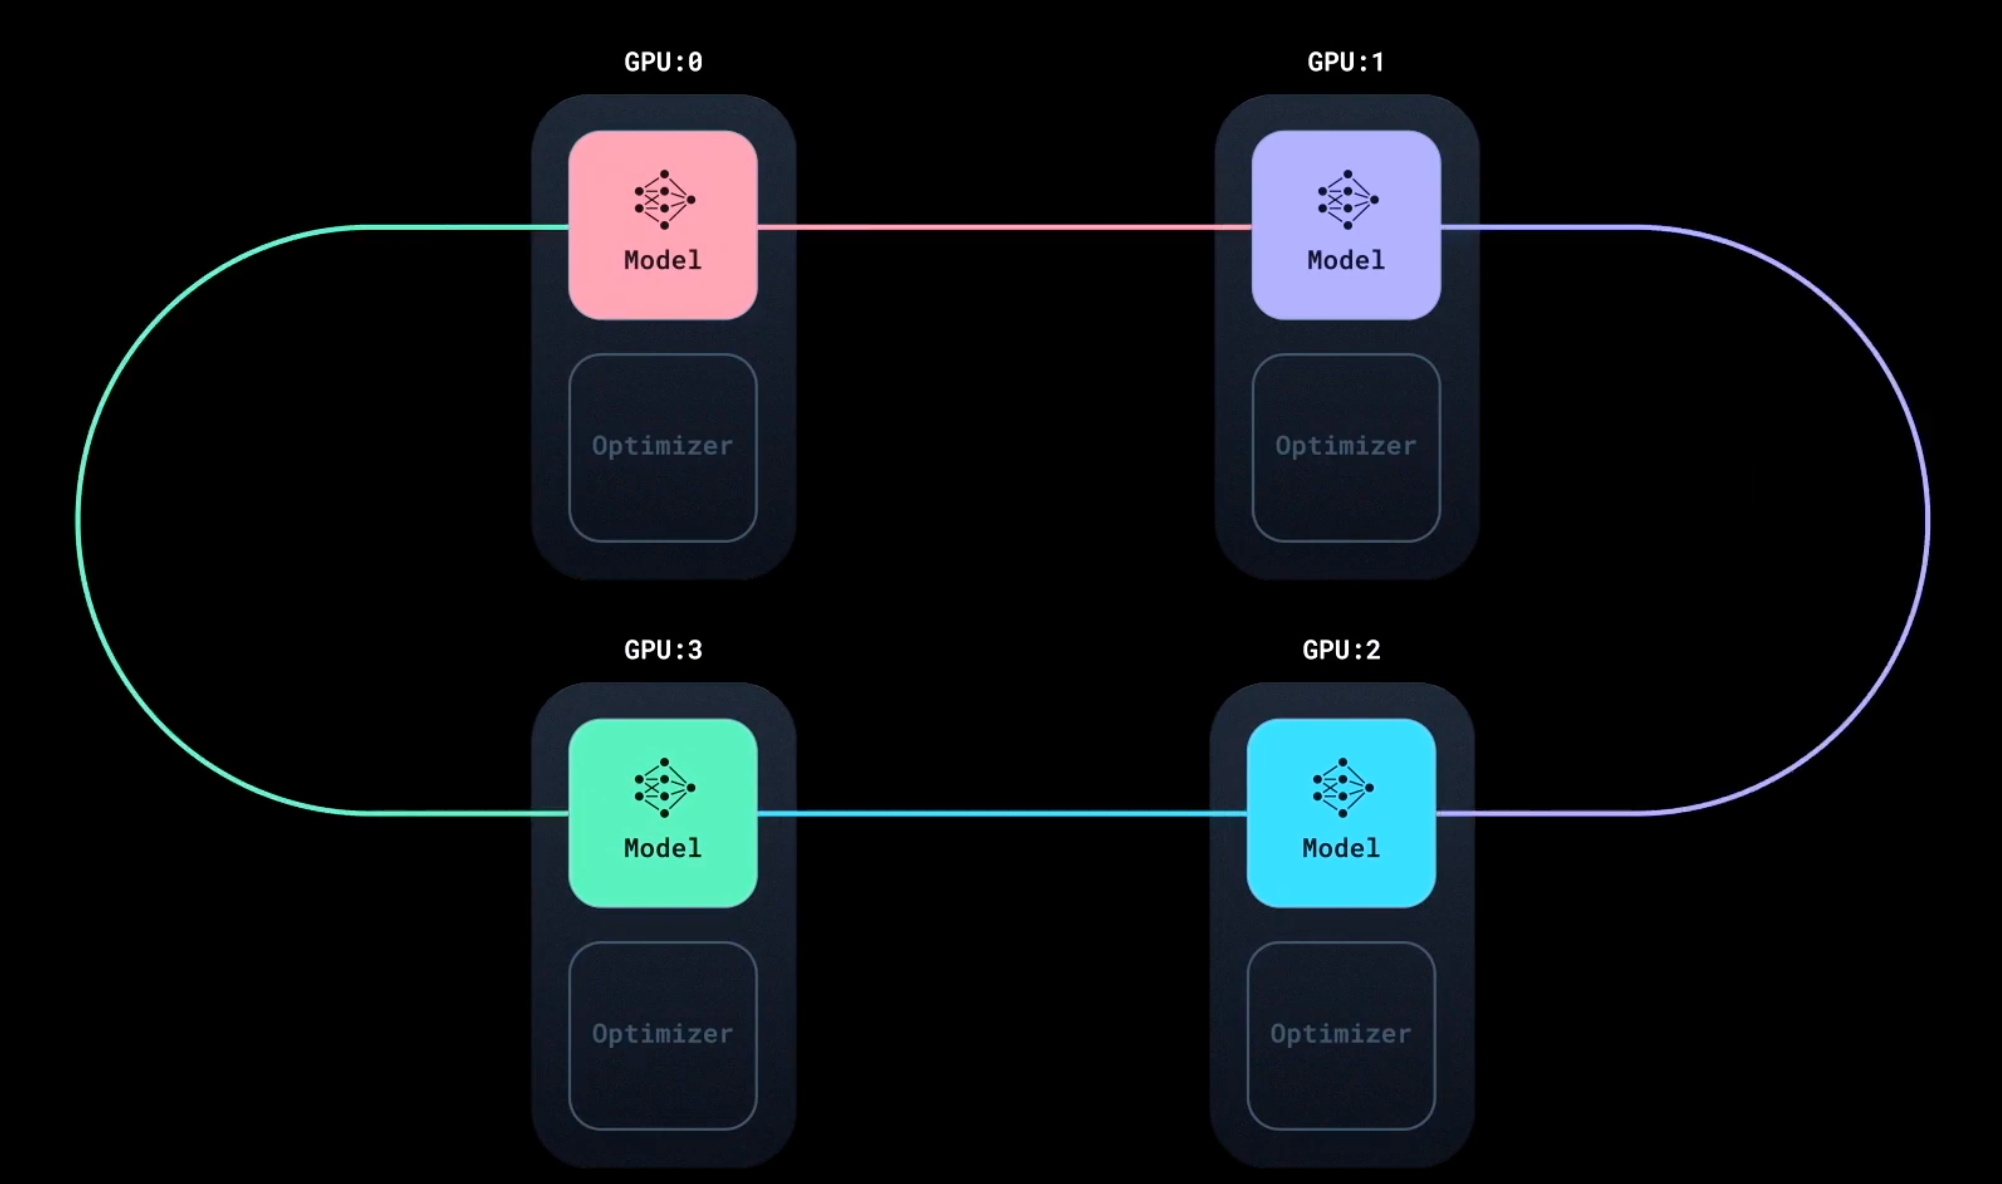

In [3]:
Image('./imgs/syn-gpus.png', width=600)

- 如上图所示：
    - 首先会将所有的gpu cards连成一个ring
    - 其同步过程，不需要等待所有的卡都计算完一轮梯度
    - 经过这个同步过程之后，所有的卡的models/optimizers就都会保持一致的状态

### DDP的基本的相关概念
#### node, rank, world_size

- node 物理节点，就是一台机器，节点内部可以有多个GPU
- rank & local_rank 用于表示进程的序号，用于进程间通信。每一个进程对应了一个rank
    - rank=0的进程就是master进程
    - rank是指在整个分布式任务中进程的序号；local_rank是指在一台机器上（一个node上）进程的相对序号，例如机器一上有0，1，2，3，...，机器二上也有0,1,2,3，...，这些进程的rank都是不同的，但是local_rank都是从0开始的(单机多卡的时候，rank就是local_rank)

在使用DDP的时候需要先进行setup

```python
def ddp_setup(rank, world_size):
    """
    Args:
        rank: Unique identifier of each process
        world_size: Total number of processes
    """
    os.environ["MASTER_ADDR"] = "localhost"
    os.environ["MASTER_PORT"] = "12355"
    init_process_group(backend="nccl", rank=rank, world_size=world_size)
    torch.cuda.set_device(rank)